# Randomized Kaczmarz algorithm assuming sparse system --- Sequential solver

In [1]:
import os, math, time

# For forcing Python to run one core only for NUMPY analysis
# For fair comparison with other algorithms
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
import numpy.matlib
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import h5py
plt.style.use('default')

from harmonic_helper import *

In [2]:
fname = "3D_face_k_60.mat"
#fname = "right_hemisphere_brain.mat"
#fname = "right_hemisphere_brain_k_60.mat"
#fname = "left_hemisphere_brain_k_60.mat"
#fname = "matterhorn_example.mat"

v, D_mat = HarmIO.read_hdf5(fname)
D = D_mat.T
V = v.T

sampled_rows = int(20000)
_ip = np.random.permutation(len(D[:,1]))
_idel = _ip[:sampled_rows]
D0 = D[_idel,:]
V0 = V[_idel,:]

_m, _n = D.shape
_m2, _n2 = D0.shape
print("System size is {} rows and {} columns for {} degrees".format(_m, _n, int(np.sqrt(_n)-1)))
print("The sparse system size is {} rows and {} columns for {} degrees".format(_m2, _n2, int(np.sqrt(_n2)-1)))
if _m2 < _n2:
    print("The sparse system is underdetermined.")
elif _m2 > _n2:
    print("The sparse system is overdetermined.")
else:
    print("The sparse system is determined.")

System size is 132730 rows and 3721 columns for 60 degrees
The sparse system size is 20000 rows and 3721 columns for 60 degrees
The sparse system is overdetermined.


## Least squares solution - Parallel


Solver's time: 6.049556994438172 min


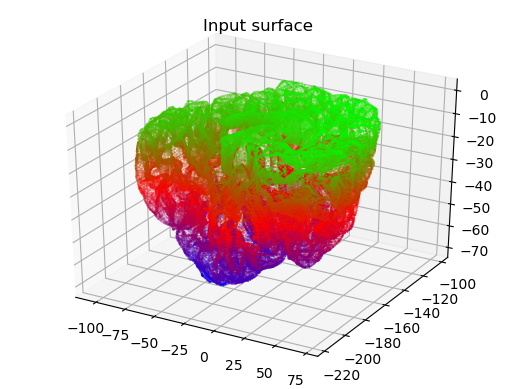

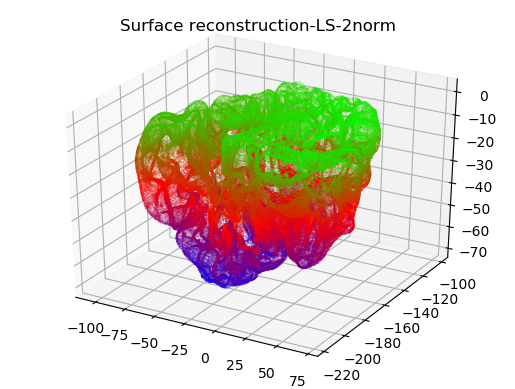

0.6443708004909583


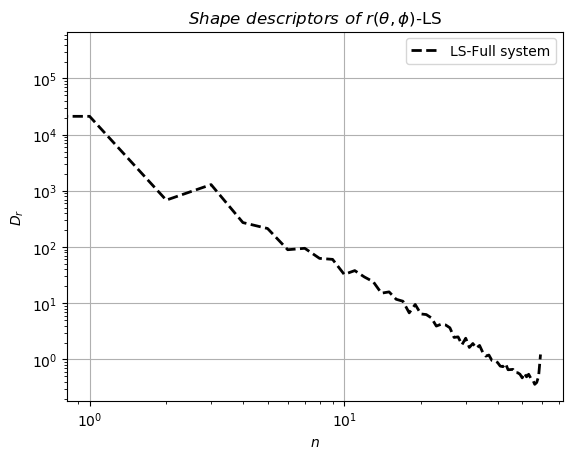

In [5]:
# The fastest parallel Least-squares solver (uses all the cores!)
coefs_LS = L2Solvers.solve_2_norm(D, V)

ax = plt.axes(projection='3d')
ax.scatter3D(V[:, 1], V[:, 2], V[:, 0], c=V[:, 0], s=0.1, cmap='brg');
plt.title("Input surface")
plt.show()

V1 = np.real(D @ coefs_LS)
ax = plt.axes(projection='3d')
ax.scatter3D(V1[:, 1], V1[:, 2], V1[:, 0], c=V1[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-LS-2norm")
plt.show()

Dx_LS, Dy_LS, Dz_LS = shape_descriptors(coefs_LS)
Dr_LS = Dx_LS + Dy_LS + Dz_LS
plt.figure()
plt.loglog(np.arange(len(Dr_LS)), Dr_LS, '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');
HarmIO.export_mat("./postprocessing/"+"rec_"+fname[:-4]+"_LS.mat", {"qm_k": coefs_LS})

calc_rec_error = lambda Xs, v: np.sqrt(np.mean(( (D @ Xs).real - v)**2.0))
rec_error_x_LLS = calc_rec_error(coefs_LS[:, 0], V[:, 0])
rec_error_y_LLS = calc_rec_error(coefs_LS[:, 1], V[:, 1])
rec_error_z_LLS = calc_rec_error(coefs_LS[:, 2], V[:, 2])
rec_error_radial_LLS = np.mean([rec_error_x_LLS, rec_error_y_LLS, rec_error_z_LLS])
print(rec_error_radial_LLS)

HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_LS.harmIO", {"Dr_LS": Dr_LS, "coefs_LS": coefs_LS, "RMSE_avg": rec_error_radial_LLS})

## Randomized Kaczmarz with Sparse-CS first round

In [3]:
max_iter = 37
relax = 0.3
support_size = 500

t1 = time.time()
x_RK_solver = Kaczmarz_solver(D0, V0[:, 0], x0=[], iterations = max_iter, relaxation = relax)
coef_x_kz = x_RK_solver.solve_Kaczmarz_sparse_conj_sym(support_size)
del x_RK_solver

y_RK_solver = Kaczmarz_solver(D0, V0[:, 1], x0=[], iterations = max_iter, relaxation = relax)
coef_y_kz = y_RK_solver.solve_Kaczmarz_sparse_conj_sym(support_size)
del y_RK_solver

z_RK_solver = Kaczmarz_solver(D0, V0[:, 2], x0=[], iterations = max_iter, relaxation = relax)
coef_z_kz = z_RK_solver.solve_Kaczmarz_sparse_conj_sym(support_size)
del z_RK_solver

In [5]:
del z_RK_solver
coefs_RK = np.array([coef_x_kz, coef_y_kz, coef_z_kz]).T

print("Overall processing time is {} min".format((time.time()-t1)/60))
HarmIO.export_mat("./postprocessing/"+"rec_"+fname[:-4]+"_SRK_1.mat", {"qm_k": coefs_RK})

Overall processing time is 7.487499868869781 min


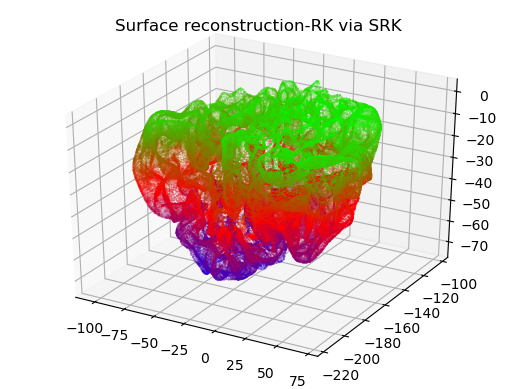

NameError: name 'Dr_LS' is not defined

<Figure size 640x480 with 0 Axes>

In [6]:
V2 = np.real(D @ coefs_RK)
ax = plt.axes(projection='3d')
ax.scatter3D(V2[:, 1], V2[:, 2], V2[:, 0], c=V2[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK via SRK")
plt.show()

Dx_RK, Dy_RK, Dz_RK = shape_descriptors(coefs_RK)
Dr_RK = Dx_RK + Dy_RK + Dz_RK

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=2, markersize=10, label='RK-Full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [5]:
rec_steps = 1000

rec_error_x = x_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_y = y_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_z = z_RK_solver.reconstruct_history(rec_steps = rec_steps)
HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_SRK_1.harmIO",
                        {"Dr_RK": Dr_RK, "coefs_RK": coefs_RK, "rec_error_x":rec_error_x, "rec_error_y":rec_error_y, "rec_error_z":rec_error_z})

In [6]:
plt.figure()
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")
plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

In [7]:
calc_rec_error = lambda Xs, v: np.sqrt(np.mean(( (D @ Xs).real - v)**2.0))

rec_error_x_LLS = calc_rec_error(coefs_RK[:, 0], V[:, 0])
rec_error_y_LLS = calc_rec_error(coefs_RK[:, 1], V[:, 1])
rec_error_z_LLS = calc_rec_error(coefs_RK[:, 2], V[:, 2])
rec_error_radial_LLS = np.mean([rec_error_x_LLS, rec_error_y_LLS, rec_error_z_LLS])
print(rec_error_radial_LLS)

1.1574735353539916


# Second round iterations with RK-CS

In [ ]:
max_iter = 3
relax = 0.3

t1 = time.time()
x_RK_solver = Kaczmarz_solver(D, V[:, 0], x0 = coef_x_kz, iterations = max_iter, relaxation = relax)
coef_x_kz2 = x_RK_solver.solve_Kaczmarz_conjugate_sym()
del x_RK_solver
y_RK_solver = Kaczmarz_solver(D, V[:, 1], x0 = coef_y_kz, iterations = max_iter, relaxation = relax)
coef_y_kz2 = y_RK_solver.solve_Kaczmarz_conjugate_sym()
del y_RK_solver

z_RK_solver = Kaczmarz_solver(D, V[:, 2], x0 = coef_z_kz, iterations = max_iter, relaxation = relax)
coef_z_kz2 = z_RK_solver.solve_Kaczmarz_conjugate_sym()
del z_RK_solver

coefs_RK2 = np.array([coef_x_kz2, coef_y_kz2, coef_z_kz2]).T

print("Overall processing time is {} min".format((time.time()-t1)/60))
HarmIO.export_mat("./postprocessing/"+"rec_"+fname[:-4]+"_SRKCS_RK.mat", {"qm_k": coefs_RK2})


Solver's time: 39.87521433830261 sec

Solver's time: 39.60886263847351 sec


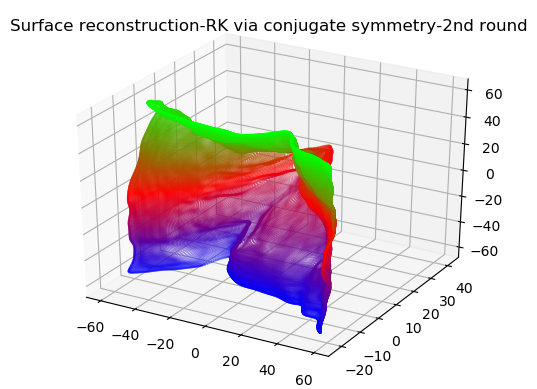

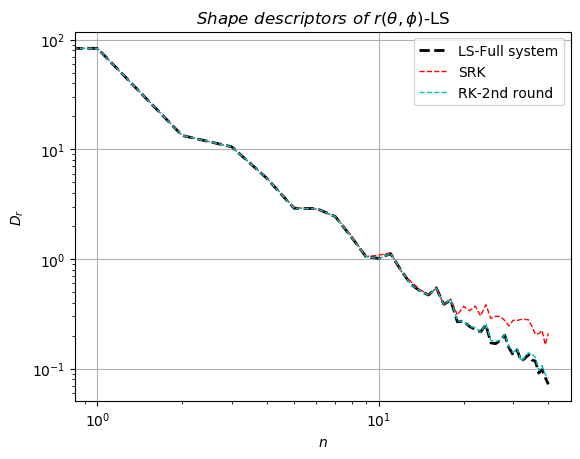

In [15]:
V3 = np.real(D @ coefs_RK2)
ax = plt.axes(projection='3d')
ax.scatter3D(V3[:, 1], V3[:, 2], V3[:, 0], c=V3[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK via conjugate symmetry-2nd round")
plt.show()

Dx_RK2, Dy_RK2, Dz_RK2 = shape_descriptors(coefs_RK2)
Dr_RK2 = Dx_RK2 + Dy_RK2 + Dz_RK2

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=1, markersize=10, label='SRK')
plt.loglog(np.arange(len(Dr_RK2)), np.sqrt(Dr_RK2), '--c', linewidth=1, markersize=10, label='RK-2nd round')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [16]:
rec_steps = 1000

rec_error_x2 = x_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_y2 = y_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_z2 = z_RK_solver.reconstruct_history(rec_steps = rec_steps)
HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_SRKCS_RK.harmIO",
                        {"Dr_RK": Dr_RK2, "coefs_RK": coefs_RK2, "rec_error_x":rec_error_x2, "rec_error_y":rec_error_y2, "rec_error_z":rec_error_z2})

In [16]:
calc_rec_error = lambda Xs, v: np.sqrt(np.mean(( (D @ Xs).real - v)**2.0))

rec_error_x_LLS = calc_rec_error(coefs_RK2[:, 0], V[:, 0])
rec_error_y_LLS = calc_rec_error(coefs_RK2[:, 1], V[:, 1])
rec_error_z_LLS = calc_rec_error(coefs_RK2[:, 2], V[:, 2])
rec_error_radial_LLS = np.mean([rec_error_x_LLS, rec_error_y_LLS, rec_error_z_LLS])
print(rec_error_radial_LLS)

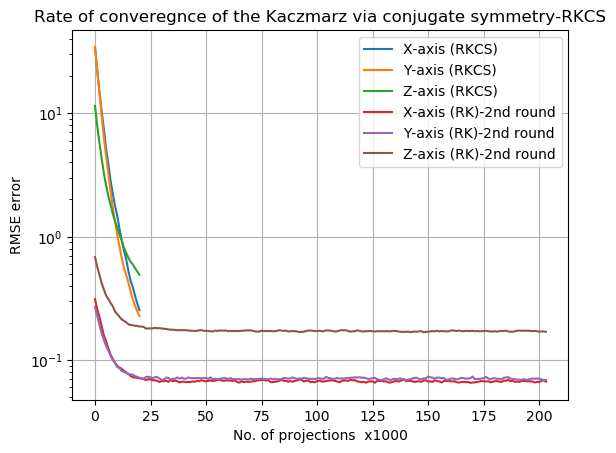

In [17]:
plt.figure()
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")

plt.semilogy(rec_error_x2, label="X-axis (RK)-2nd round")
plt.semilogy(rec_error_y2, label="Y-axis (RK)-2nd round")
plt.semilogy(rec_error_z2, label="Z-axis (RK)-2nd round")

plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

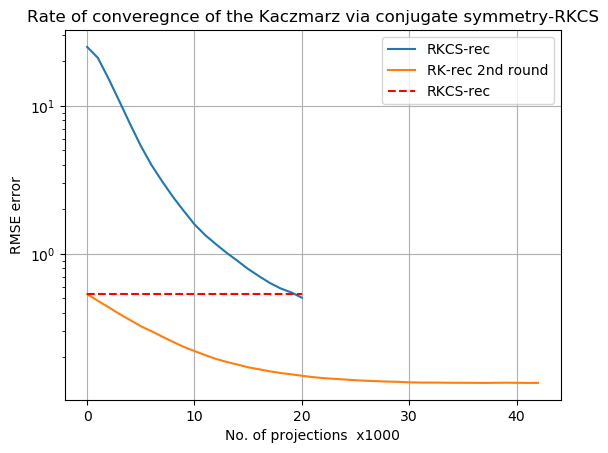

In [37]:
mean_rec_error = np.mean(np.array([rec_error_x, rec_error_y, rec_error_z]), axis=0)
mean_rec_error2 = np.mean(np.array([rec_error_x2, rec_error_y2, rec_error_z2]), axis=0)

plt.figure()
plt.semilogy(mean_rec_error, label="RKCS-rec")
plt.semilogy(mean_rec_error2, label="RK-rec 2nd round")
plt.semilogy(np.arange(mean_rec_error.shape[0]), np.ones(mean_rec_error.shape)*mean_rec_error2[0], '--r', label="RKCS-rec")

plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

## Randomized Kaczmarz with with CS

In [3]:
max_iter = 5.5
relax = 0.3

t1 = time.time()
x_RK_solver = Kaczmarz_solver(D, V[:, 0], x0=[], iterations = max_iter, relaxation = relax)
coef_x_kz3 = x_RK_solver.solve_Kaczmarz_conjugate_sym()
del x_RK_solver
y_RK_solver = Kaczmarz_solver(D, V[:, 1], x0=[], iterations = max_iter, relaxation = relax)
coef_y_kz3 = y_RK_solver.solve_Kaczmarz_conjugate_sym()
del y_RK_solver
z_RK_solver = Kaczmarz_solver(D, V[:, 2], x0=[], iterations = max_iter, relaxation = relax)
coef_z_kz3 = z_RK_solver.solve_Kaczmarz_conjugate_sym()
del z_RK_solver

coefs_RK3 = np.array([coef_x_kz3, coef_y_kz3, coef_z_kz3]).T

print("Overall processing time is {} min".format((time.time()-t1)/60))
HarmIO.export_mat("./postprocessing/"+"rec_"+fname[:-4]+"_RKCS.mat", {"qm_k": coefs_RK3})


Solver's time: 84.35030317306519 sec

Solver's time: 83.97148561477661 sec

Solver's time: 84.83491015434265 sec
Overall processing time is 4.9777821660041806 min


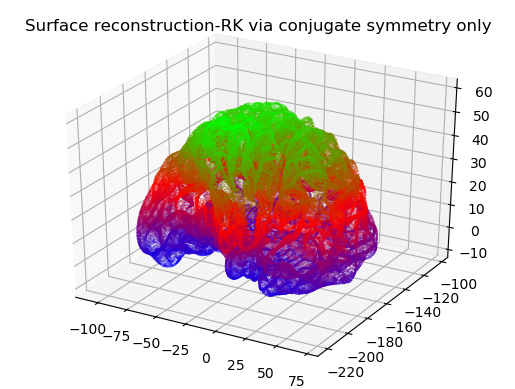

NameError: name 'Dr_LS' is not defined

<Figure size 640x480 with 0 Axes>

In [31]:
V4 = np.real(D @ coefs_RK3)
ax = plt.axes(projection='3d')
ax.scatter3D(V4[:, 1], V4[:, 2], V4[:, 0], c=V4[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK via conjugate symmetry only")
plt.show()

Dx_RK3, Dy_RK3, Dz_RK3 = shape_descriptors(coefs_RK3)
Dr_RK3 = Dx_RK3 + Dy_RK3 + Dz_RK3

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=1, markersize=10, label='SRK')
plt.loglog(np.arange(len(Dr_RK2)), np.sqrt(Dr_RK2), '--c', linewidth=1, markersize=10, label='RK-2nd round')
plt.loglog(np.arange(len(Dr_RK3)), np.sqrt(Dr_RK3), '--b', linewidth=1, markersize=10, label='RK-Only full system')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [22]:
'''
rec_steps = 1000
rec_error_x3 = x_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_y3 = y_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_z3 = z_RK_solver.reconstruct_history(rec_steps = rec_steps)

HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_RKCS.harmIO",
                        {"Dr_RK": Dr_RK3, "coefs_RK": coefs_RK3, "rec_error_x":rec_error_x3, "rec_error_y":rec_error_y3, "rec_error_z":rec_error_z3})
                        

'''

HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_RKCS.harmIO",
                        {"Dr_RK": Dr_RK3, "coefs_RK": coefs_RK3})

In [ ]:
plt.figure()
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")

plt.semilogy(rec_error_x2, label="X-axis (RK)-2nd round")
plt.semilogy(rec_error_y2, label="Y-axis (RK)-2nd round")
plt.semilogy(rec_error_z2, label="Z-axis (RK)-2nd round")

plt.semilogy(rec_error_x3, label="X-axis (RK)-Only full system")
plt.semilogy(rec_error_y3, label="Y-axis (RK)-Only full system")
plt.semilogy(rec_error_z3, label="Z-axis (RK)-Only full system")

plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

In [4]:
calc_rec_error = lambda Xs, v: np.sqrt(np.mean(( (D @ Xs).real - v)**2.0))

rec_error_x_LLS = calc_rec_error(coefs_RK3[:, 0], V[:, 0])
rec_error_y_LLS = calc_rec_error(coefs_RK3[:, 1], V[:, 1])
rec_error_z_LLS = calc_rec_error(coefs_RK3[:, 2], V[:, 2])
rec_error_radial_LLS = np.mean([rec_error_x_LLS, rec_error_y_LLS, rec_error_z_LLS])
print(rec_error_radial_LLS)


0.8153435950143955


In [7]:
mean_rec_error3 = np.mean(np.array([rec_error_x3, rec_error_y3, rec_error_z3]), axis=0)
print(mean_rec_error3[-1])
plt.figure()
plt.semilogy(mean_rec_error, label="SRK-CS")
plt.semilogy(mean_rec_error2, label="RK-rec 2nd round")
plt.semilogy(mean_rec_error3, label="RK-Only full system")
plt.semilogy(np.arange(mean_rec_error.shape[0]), np.ones(mean_rec_error.shape)*mean_rec_error2[0], '--r')
plt.semilogy(np.arange(mean_rec_error3.shape[0]), np.ones(mean_rec_error3.shape)*mean_rec_error3[-1], '--r')

plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

0.13435744222617166


NameError: name 'mean_rec_error' is not defined

<Figure size 640x480 with 0 Axes>

## Randomized Kaczmarz only

In [ ]:
max_iter = 5.5
relax = 0.3

t1 = time.time()
x_RK_solver = Kaczmarz_solver(D, V[:, 0], x0=[], iterations = max_iter, relaxation = relax)
y_RK_solver = Kaczmarz_solver(D, V[:, 1], x0=[], iterations = max_iter, relaxation = relax)
z_RK_solver = Kaczmarz_solver(D, V[:, 2], x0=[], iterations = max_iter, relaxation = relax)

coef_x_kz4 = x_RK_solver.solve_Kaczmarz()
del x_RK_solver
coef_y_kz4 = y_RK_solver.solve_Kaczmarz()
del y_RK_solver
coef_z_kz4 = z_RK_solver.solve_Kaczmarz()
del z_RK_solver

coefs_RK4 = np.array([coef_x_kz4, coef_y_kz4, coef_z_kz4]).T

print("Overall processing time is {} min".format((time.time()-t1)/60))
HarmIO.export_mat("./postprocessing/"+"rec_"+fname[:-4]+"_RK.mat", {"qm_k": coefs_RK4})

In [ ]:
V5 = np.real(D @ coefs_RK4)
ax = plt.axes(projection='3d')
ax.scatter3D(V5[:, 1], V5[:, 2], V5[:, 0], c=V5[:, 0], s=0.1, cmap='brg');
plt.title("Surface reconstruction-RK only")
plt.show()

Dx_RK4, Dy_RK4, Dz_RK4 = shape_descriptors(coefs_RK4)
Dr_RK4 = Dx_RK4 + Dy_RK4 + Dz_RK4

plt.figure()
plt.loglog(np.arange(len(Dr_LS)), np.sqrt(Dr_LS), '--k', linewidth=2, markersize=10, label='LS-Full system')
plt.loglog(np.arange(len(Dr_RK)), np.sqrt(Dr_RK), '--r', linewidth=1, markersize=10, label='SRK')
plt.loglog(np.arange(len(Dr_RK2)), np.sqrt(Dr_RK2), '--c', linewidth=1, markersize=10, label='RK-2nd round')
plt.loglog(np.arange(len(Dr_RK3)), np.sqrt(Dr_RK3), '--b', linewidth=1, markersize=10, label='RK-Only full system')
plt.loglog(np.arange(len(Dr_RK4)), np.sqrt(Dr_RK4), '--y', linewidth=1, markersize=10, label='RK-Only without CS')
plt.ylabel(r'$D_r$')
plt.xlabel(r'$n$')
plt.grid()
plt.legend()
plt.title(r'$Shape~descriptors~of~r(\theta, \phi)$-LS');

In [5]:
'''
rec_error_x4 = x_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_y4 = y_RK_solver.reconstruct_history(rec_steps = rec_steps)
rec_error_z4 = z_RK_solver.reconstruct_history(rec_steps = rec_steps)

HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_RK.harmIO",
                        {"Dr_RK": Dr_RK4, "coefs_RK": coefs_RK4, "rec_error_x":rec_error_x4, "rec_error_y":rec_error_y4, "rec_error_z":rec_error_z4})
'''
HarmIO.export_variables("./postprocessing/"+"rec_"+fname[:-4]+"_RK.harmIO",
                        {"Dr_RK": Dr_RK4, "coefs_RK": coefs_RK4})

In [ ]:
plt.figure()
plt.semilogy(rec_error_x, label="X-axis (RKCS)")
plt.semilogy(rec_error_y, label="Y-axis (RKCS)")
plt.semilogy(rec_error_z, label="Z-axis (RKCS)")

plt.semilogy(rec_error_x2, label="X-axis (RK)-2nd round")
plt.semilogy(rec_error_y2, label="Y-axis (RK)-2nd round")
plt.semilogy(rec_error_z2, label="Z-axis (RK)-2nd round")

plt.semilogy(rec_error_x3, label="X-axis (RK)-Only full system")
plt.semilogy(rec_error_y3, label="Y-axis (RK)-Only full system")
plt.semilogy(rec_error_z3, label="Z-axis (RK)-Only full system")

plt.semilogy(rec_error_x4, label="X-axis (RK)- without CS")
plt.semilogy(rec_error_y4, label="Y-axis (RK)- without CS")
plt.semilogy(rec_error_z4, label="Z-axis (RK)- without CS")

plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();

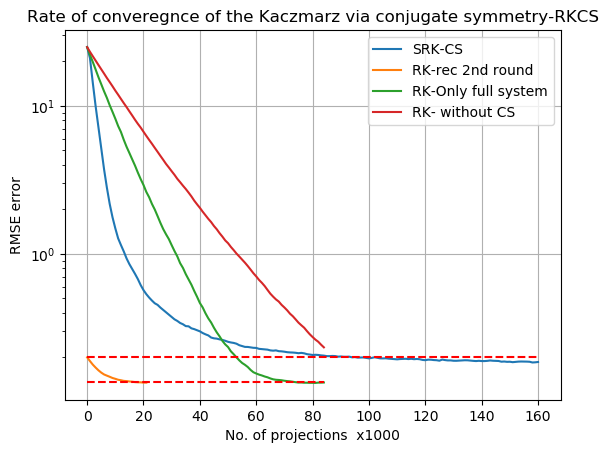

In [28]:
mean_rec_error4 = np.mean(np.array([rec_error_x4, rec_error_y4, rec_error_z4]), axis=0)

plt.figure()
plt.semilogy(mean_rec_error, label="SRK-CS")
plt.semilogy(mean_rec_error2, label="RK-rec 2nd round")
plt.semilogy(mean_rec_error3, label="RK-Only full system")
plt.semilogy(mean_rec_error4, label="RK- without CS")
plt.semilogy(np.arange(mean_rec_error.shape[0]), np.ones(mean_rec_error.shape)*mean_rec_error2[0], '--r')
plt.semilogy(np.arange(mean_rec_error3.shape[0]), np.ones(mean_rec_error3.shape)*mean_rec_error3[-1], '--r')

plt.xlabel("No. of projections  x{}".format(rec_steps))
plt.ylabel("RMSE error")
plt.legend()
plt.grid()
plt.title(r'Rate of converegnce of the Kaczmarz via conjugate symmetry-RKCS')
plt.show();